# 00.0 Transfer learning with deep convolutional neural network for liver steatosis assessment in ultrasound images
Reproduce Results of [Transfer learning with deep convolutional neural network for liver steatosis assessment in ultrasound images](https://pubmed.ncbi.nlm.nih.gov/30094778/)







In [1]:
import sys
sys.path.append('../src')
from scipy.io import loadmat
from pprint import pprint
import pandas as pd
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import pickle
from PIL import Image
from pathlib import Path
import yaml
import os
from cld_ivado.utils.neural_networks_utils import get_all_transformations
from cld_ivado.dataset.dl_dataset import CldIvadoDataset
from cld_ivado.utils.dataframe_creation import create_dataframe_preproccessing

In [2]:
M, N= 434, 636 # ultrasound image dimension

In [3]:
parameters_file ='parameters_resnet18.yml'
current_dir = Path.cwd()
#proj_path = current_dir.parent
proj_path = current_dir.parent
# make the code in src available to import in this notebook
sys.path.append(os.path.join(proj_path, 'src'))

# Catalog contains all the paths related to datasets
with open(os.path.join(proj_path, 'conf/data_catalog.yml'), "r") as f:
    catalog = yaml.safe_load(f)

# Params contains all of the dataset creation parameters and model parameters
with open(os.path.join(proj_path, f'conf/{parameters_file}'), "r") as f:
    params = yaml.safe_load(f)

## Import Dataset of B-mode fatty liver ultrasound images

This notebook shows how to convert the dataset_liver_bmodes_steatosis_assessment_IJCARS.mat dataset.

Download the [dataset](https://www.kaggle.com/shanecandoit/dataset-of-bmode-fatty-liver-ultrasound-images?select=Byra2018_Article_TransferLearningWithDeepConvol.pdf.) first. 


> Our study involved 55 severely obese patients (mean age 40.1 ± 9.1, mean BMI 45.9 ± 5.6, 20% of males) admitted for bariatric surgery (laparoscopic sleeve gastrectomy). The ultrasound data were acquired using the GE Vivid E9 Ultrasound System (GE Healthcare INC, Horten, Nor- way) equipped with a sector probe operating at 2.5 MHz. The default general abdominal preset with harmonic imag- ing was used.










> The fatty liver was defined to have more than 5% hepatocytes with steatosis. The number of patients with fatty liver was equal to 38.

See the histogram below for the level distribution across patients. 


In [4]:
data= loadmat(os.path.join(catalog['data_root'],catalog['01_raw_mat']))
df = pd.DataFrame()
for patient in data['data'][0]:
    p_id = patient[0][0][0]
    p_class = patient[1][0][0]
    p_fat = patient[2][0][0]
    for i,p_image in enumerate(patient[3]):
        
        
        patient_row = pd.DataFrame({'id':p_id,
                                    'class':p_class,
                                    'fat':p_fat,
                                    'img':[torch.tensor(p_image).view(1,M,N).type(torch.float32)]})
        df = df.append(patient_row,)
        Image.fromarray(np.uint8(p_image)).save(os.path.join(catalog['data_root'],f'data/01_raw/raw_images/P{p_id}_image{i+1}.jpg'))

df.reset_index(drop=True, inplace=True)

In [5]:
#save dataset in order to use it later
with open(os.path.join(catalog['data_root'],catalog['02_interim_pd']), 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

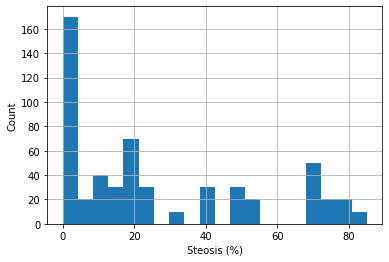

In [7]:
df['fat'].hist(bins=20)
plt.xlabel('Steosis (%)')
plt.ylabel('Count')
plt.show()

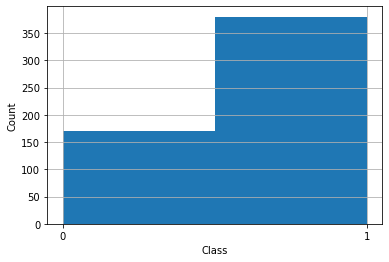

In [8]:
df['class'].hist(bins=2)
plt.xlabel('Class')
plt.ylabel('Count')
plt.locator_params(axis='x', integer=True)
plt.show()

## Step 2:  See Samples of US

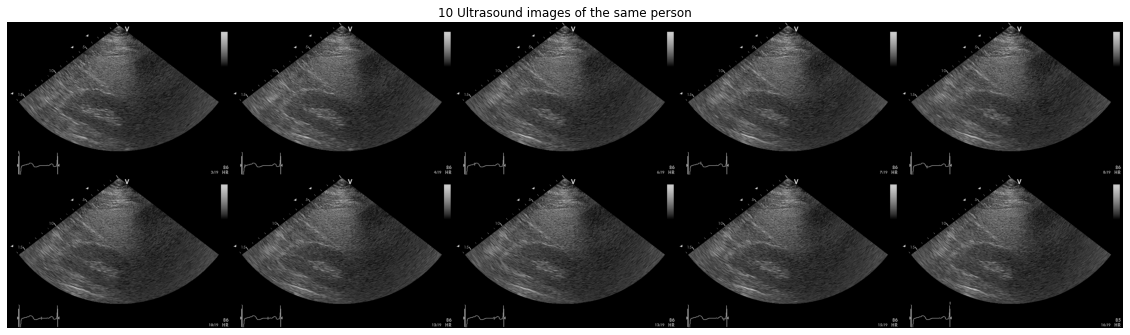

In [9]:
my_img_grid = df['img'].iloc[430].view(1,1,434,636)
for i in range(431,440):
    # my_img_grid[i,None] = df['img'].iloc[i]
    my_img_grid = torch.cat([my_img_grid,df['img'].iloc[i].view(1,1,434,636)])


def imshow(img):
    plt.figure(figsize=(20,20))
    plt.axis("off")
    plt.title("10 Ultrasound images of the same person")
    #img = img / 2 + 0.5     # unnormalize
    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(my_img_grid.type(torch.int), nrow=5))
# print( "The shape of the images is", images.shape)

## Step 3:  See Samples of transformed US

In [38]:
dataset = pd.read_pickle(os.path.join(catalog['data_root'], catalog['02_interim_pd']))
dataset = create_dataframe_preproccessing(dataset)

df_pid = dataset['id']
df_y = dataset['labels']
df_fat = dataset['fat']
is_rgb = params['model']['is_rgb']
random_crop_size= 224

In [39]:
data_transforms = {'train': transforms.Compose([
    transforms.Resize(random_crop_size),
    transforms.RandomAffine(degrees=(-15, 15), translate=(0.15, 0.15)),
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
    'val': transforms.Compose([
    transforms.Resize(random_crop_size),
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])}


In [40]:
dataset_train = CldIvadoDataset(dataset, catalog['data_root'], 'labels', 'fname', 
                                data_transforms['train'], is_rgb = is_rgb)

In [41]:
dataloaders = {'train': torch.utils.data.DataLoader(dataset_train, 
                                                          batch_size=params['model']['batch_size'], 
                                                          shuffle=False)}

In [42]:
for inputs, labels in dataloaders['train']:
    #torchvision.transforms.ToPILImage
    inputs[0]
    break
    

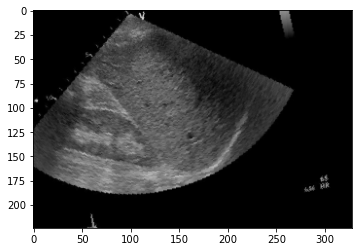

In [43]:
img = inputs[0]
#convert image back to Height,Width,Channels
inputs = np.transpose(inputs[0], (1,2,0))
#show the image
plt.imshow(inputs)
plt.show()